

# Exploratory Data Analysis  

  


In [ ]:
!pip install optuna

In [2]:
# Data manipulation and computation
import pandas as pd  
import numpy as np  
from decimal import Decimal  
import re  

# Visualization libraries
import matplotlib.pyplot as plt  
import seaborn as sns  

# Statistical tools
from scipy import stats  

# Machine learning
from sklearn.model_selection import KFold  
from sklearn.metrics import roc_auc_score, log_loss, precision_score, recall_score, f1_score  
from sklearn.impute import SimpleImputer, IterativeImputer  
from sklearn.experimental import enable_iterative_imputer  
from sklearn.feature_selection import SelectFromModel  

# Machine learning: Model training
import xgboost as xgb  

# Hyperparameter optimization
import optuna  


In [3]:
data = pd.read_parquet("C:/Users/shuti/Documents/Downloads/catB_train.parquet")
pd.set_option('display.max_rows', None)

target = 'f_purchase_lh'

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17992 entries, 19550 to 15795
Columns: 304 entries, clntnum to f_purchase_lh
dtypes: float64(44), int64(46), object(214)
memory usage: 41.9+ MB


### Inspect unique values of each column in data

In [5]:
for column in data.columns:
    print(f"Unique values in '{column}': {data[column].unique()}")

Unique values in 'clntnum': ['91b546e924' '896bae548c' 'f364439ae6' ... '6e44cfb3e7' 'dd4e362f9f'
 '3788d06ec7']
Unique values in 'race_desc': ['Chinese' 'Others' 'Indian' None 'Malay']
Unique values in 'ctrycode_desc': ['Singapore' 'Not Applicable' 'Malaysia' 'United Kingdom'
 'Brunei Darussalam' 'Hong Kong' 'Indonesia' 'Philippines' 'Thailand'
 'Australia' None 'United Arab Emirates' 'Japan' 'Spain' 'China'
 'Taiwan (R.O.C)' 'United States' 'Denmark' 'Unknown Country Code'
 'South Africa' 'Sweden' 'Ireland' 'New Zealand' 'Netherlands' 'Italy'
 'Bosnia-Herzegovina' 'Canada']
Unique values in 'clttype': ['P' 'G' 'C']
Unique values in 'stat_flag': ['ACTIVE' 'LAPSED' 'MATURED']
Unique values in 'min_occ_date': ['2017-10-31' '2007-05-23' '2019-08-31' ... '2015-04-03' '2012-07-05'
 '1990-03-20']
Unique values in 'cltdob_fix': ['1974-05-09' '1979-11-11' '1976-01-28' ... '1948-12-16' '1967-12-06'
 '1970-05-15']
Unique values in 'cltsex_fix': ['Female' 'Male' None]
Unique values in 'flg_subst

## Inspecting the policies
There are 5 types of policies:
1. general insurance (gi)
2. group policies (grp)
3. investment-linked policies (inv)
4. life or health insurance (lh)
5. long-term care insurance (ltc)

The suffixes (e.g. 42e115, 1280bf) are unique identifiers for the specific insurance products. 

Based on observation of the above + description in NUS-SDS-Datathon GitHub, there are different types of policies and under each of them are specific policies with their unique identifiers. We have also observed a specific policy with identifier '32c74c' that does not seem to be under any policy type although it is found in:  
ape_32c74c                                  float64  
sumins_32c74c                               float64  
prempaid_32c74c                             float64  
lapse_ape_32c74c                            float64  
n_months_since_lapse_32c74c                 float64  
f_ever_bought_32c74c                          int64  
n_months_last_bought_32c74c                   int64  

  
'14cb37' also does not seem to be under any policy type although it is found in:  
flg_hlthclaim_14cb37_ever                   float64  
recency_hlthclaim_14cb37                    float64


In [6]:
def extract_unique_identifiers(columns):
    policy_types = ['gi', 'grp', 'inv', 'lh', 'ltc']
    identifiers = {ptype: set() for ptype in policy_types}

    for col in columns:
        for ptype in policy_types:
            match = re.search(f"{ptype}_([a-zA-Z0-9]+)", col)
            if match:
                identifiers[ptype].add(match.group(1))

    return identifiers

unique_identifiers = extract_unique_identifiers(data.columns)
unique_identifiers['gi'].remove('claim')

for policy_type, ids in unique_identifiers.items():
    print(f"Unique identifiers for {policy_type} policies: {ids}")

Unique identifiers for gi policies: {'058815', '856320', '42e115', '29d435', 'a10d1b'}
Unique identifiers for grp policies: {'6fc3e6', 'de05ae', '9cdedf', '945b5a', 'caa6ff', 'fd3bfb', '1581d7', 'e04c3a', 'fe5fb8', '22decf', '70e1dd', '94baec', 'e91421', '6a5788'}
Unique identifiers for inv policies: {'e9f316', 'dcd836'}
Unique identifiers for lh policies: {'839f8a', 'e22a6a', '947b15', 'd0adeb', 'f852af', '507c37'}
Unique identifiers for ltc policies: {'43b9d5', '1280bf'}


## Inspect columns containing 'clmcon'
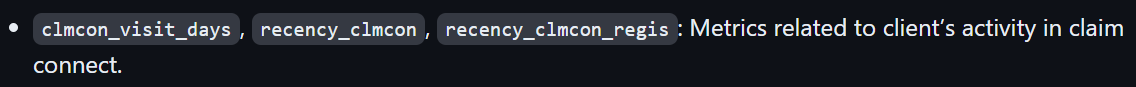
Columns containing 'clmcon' are metrics related to client’s activity in claim connect. We have searched online and found out that claim connect is Singlife's online platform for clients to submit their insurance claims

In [7]:
clmcon = [col for col in data.columns if 'clmcon' in col]
clmcon

['clmcon_visit_days', 'recency_clmcon', 'recency_clmcon_regis']

### Inspect columns related to household and population size 
![image.png](attachment:image.png

By inspecting these 4 columns, we found out that 'hh_size' contains values that can be derived from substracting 'pop_20' by 'hh_20'. Also, 'hh_size_est' is the rounded-off values of 'hh_size', except if the value in 'hh_size' exceeds 4.0, 'hh_size_est' will capture it as '>4'

In [8]:
subset = data[['hh_20', 'pop_20', 'hh_size', 'hh_size_est']].head(20)
print(subset)

      hh_20 pop_20   hh_size hh_size_est
19550   144    202  1.402778           1
4600    153    480  3.137255           3
13337    62    179  2.887097           3
15074     1      4  4.000000           4
19724   114    478  4.192982          >4
14717   138    477  3.456522           3
6307    131    418  3.190840           3
4168    233    758  3.253219           3
169     109    261  2.394495           2
11816    58     77  1.327586           1
14245   107    328  3.065421           3
4618    125    455  3.640000           4
11928  None   None       NaN        None
11195    68    186  2.735294           3
6492   None   None       NaN        None
10520    84    242  2.880952           3
18743   102    299  2.931373           3
15299    60    338  5.633333          >4
17470   221    669  3.027149           3
17726    72    151  2.097222           2


### Check for duplicate values in 'clntnum' to ensure that there are no repeated clients

In [9]:
duplicates = data['clntnum'].duplicated()
num_duplicates = duplicates.sum()
any_duplicates = duplicates.any()

print(f"Number of duplicate values in 'clntnum': {num_duplicates}")
print(f"Are there any duplicate values in 'clntnum'? {'Yes' if any_duplicates else 'No'}")

Number of duplicate values in 'clntnum': 0
Are there any duplicate values in 'clntnum'? No


### Count the number & percentage of null values in every column in data

In [10]:
null_counts = data.isnull().sum()
total_rows = len(data)
null_percentage = (null_counts / total_rows) * 100
null_stats = pd.DataFrame({'Number of Nulls': null_counts, 'Percentage of Nulls': null_percentage})

null_stats = null_stats.sort_values(by='Percentage of Nulls', ascending=False)
null_stats.head(20)

Number of Nulls  Percentage of Nulls
giclaim_cnt_unsuccess                        17992           100.000000
giclaim_cnt_success                          17992           100.000000
flg_gi_claim_856320_ever                     17992           100.000000
flg_gi_claim_42e115_ever                     17992           100.000000
flg_gi_claim_058815_ever                     17992           100.000000
flg_gi_claim_29d435_ever                     17992           100.000000
recency_giclaim_success                      17992           100.000000
recency_giclaim_unsuccess                    17992           100.000000
flg_hlthclaim_839f8a_ever                    17707            98.415963
recency_hlthclaim_839f8a                     17707            98.415963
giclaim_amt                                  17544            97.510004
recency_giclaim                              17544            97.510004
flg_affconnect_show_interest_ever            17497            97.248777
recency_hlthclaim_unsuccess                  17382            96.609604
hlthclaim_cnt_unsuccess                      17382            96.609604
recency_cancel                               17368            96.531792
tot_cancel_pols                              17368            96.531792
f_purchase_lh                                17282            96.053802
recency_clmcon_regis                         17203            95.614718
recency_clmcon                               17203            95.614718

### Number & percentage of 'None' values in each column

In [11]:
none_counts = data.apply(lambda x: (x == 'None').sum())
total_rows = len(data)
none_percentage = (none_counts / total_rows) * 100
none_stats = pd.DataFrame({'Number of None Entries': none_counts, 'Percentage of None Entries': none_percentage})

# Sort by 'Percentage of None Entries'
none_stats = none_stats.sort_values(by='Percentage of None Entries', ascending=False)
none_stats.head(20)

Number of None Entries  \
cltdob_fix                                           22   
min_occ_date                                         10   
clntnum                                               0   
n_months_since_lapse_grp_70e1dd                       0   
n_months_since_lapse_32c74c                           0   
n_months_since_lapse_lh_947b15                        0   
n_months_since_lapse_lh_f852af                        0   
n_months_since_lapse_grp_e91421                       0   
n_months_since_lapse_grp_94baec                       0   
n_months_since_lapse_grp_fe5fb8                       0   
n_months_since_lapse_grp_e04c3a                       0   
n_months_since_lapse_lh_e22a6a                        0   
f_ever_bought_e22a6a                                  0   
n_months_since_lapse_grp_fd3bfb                       0   
n_months_since_lapse_grp_caa6ff                       0   
n_months_since_lapse_inv_e9f316                       0   
n_months_since_lapse_lh_839f8a                        0   
n_months_since_lapse_lh_507c37                        0   
n_months_since_lapse_grp_22decf                       0   
f_ever_bought_839f8a                                  0   

                                 Percentage of None Entries  
cltdob_fix                                         0.122277  
min_occ_date                                       0.055580  
clntnum                                            0.000000  
n_months_since_lapse_grp_70e1dd                    0.000000  
n_months_since_lapse_32c74c                        0.000000  
n_months_since_lapse_lh_947b15                     0.000000  
n_months_since_lapse_lh_f852af                     0.000000  
n_months_since_lapse_grp_e91421                    0.000000  
n_months_since_lapse_grp_94baec                    0.000000  
n_months_since_lapse_grp_fe5fb8                    0.000000  
n_months_since_lapse_grp_e04c3a                    0.000000  
n_months_since_lapse_lh_e22a6a                     0.000000  
f_ever_bought_e22a6a                               0.000000  
n_months_since_lapse_grp_fd3bfb                    0.000000  
n_months_since_lapse_grp_caa6ff                    0.000000  
n_months_since_lapse_inv_e9f316                    0.000000  
n_months_since_lapse_lh_839f8a                     0.000000  
n_months_since_lapse_lh_507c37                     0.000000  
n_months_since_lapse_grp_22decf                    0.000000  
f_ever_bought_839f8a                               0.000000

### Number & percentage of null values in each row

In [12]:
null_counts_per_row = data.isnull().sum(axis=1)
null_percentage_per_row = (null_counts_per_row / len(data.columns)) * 100
null_stats_per_row = pd.DataFrame({'Number of Nulls per Row': null_counts_per_row, 
                                   'Percentage of Nulls per Row': null_percentage_per_row})

null_stats_per_row_sorted = null_stats_per_row.sort_values(by='Percentage of Nulls per Row', ascending=False)
print(null_stats_per_row_sorted)

       Number of Nulls per Row  Percentage of Nulls per Row
13395                      109                    35.855263
584                        109                    35.855263
9528                       109                    35.855263
1036                       109                    35.855263
6321                       109                    35.855263
17995                      109                    35.855263
4823                       109                    35.855263
16365                      109                    35.855263
14344                      109                    35.855263
12058                      109                    35.855263
14082                      109                    35.855263
4177                       109                    35.855263
19489                      109                    35.855263
16012                      109                    35.855263
13243                      109                    35.855263
4622                       109          

## Correlation Analysis for numerical columns 
Select only numerical columns for correlation analysis

In [13]:
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data[numerical_cols].corr()
print(correlation_matrix)

                                   flg_substandard  \
flg_substandard                           1.000000   
flg_is_borderline_standard                0.089340   
flg_is_revised_term                       0.005822   
flg_is_rental_flat                       -0.020403   
flg_has_health_claim                      0.069039   
flg_has_life_claim                        0.022741   
flg_gi_claim                              0.017097   
flg_is_proposal                           0.022480   
flg_with_preauthorisation                 0.027690   
flg_is_returned_mail                     -0.002559   
is_consent_to_mail                       -0.018012   
is_consent_to_email                      -0.015374   
is_consent_to_call                       -0.037448   
is_consent_to_sms                        -0.030111   
is_valid_dm                               0.109852   
is_valid_email                            0.081269   
is_housewife_retiree                      0.004386   
is_sg_pr                    

### Finding pairs with a high correlation of more than 0.95

In [14]:
highly_correlated_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        correlation_value = abs(correlation_matrix.iloc[i, j])
        
        if correlation_value > 0.95:
            col_pair = (correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_value)
            highly_correlated_pairs.append(col_pair)

for pair in highly_correlated_pairs:
    print(f"{pair[0]} and {pair[1]}: Correlation = {pair[2]}")

f_ever_bought_c4bda5 and f_hold_c4bda5: Correlation = 0.975195936874282
f_ever_bought_ltc and f_hold_ltc: Correlation = 0.9887701291463121
f_ever_bought_ltc_43b9d5 and f_hold_ltc: Correlation = 0.9742160905620069
f_ever_bought_ltc_43b9d5 and f_ever_bought_ltc: Correlation = 0.9804173015721356
f_ever_bought_inv_e9f316 and f_hold_c4bda5: Correlation = 0.975195936874282
f_ever_bought_inv_e9f316 and f_ever_bought_c4bda5: Correlation = 1.0
recency_hlthclaim_success and recency_hlthclaim: Correlation = 0.9704026539673024
recency_hlthclaim_14cb37 and recency_hlthclaim: Correlation = 0.9812371385991749
recency_hlthclaim_14cb37 and recency_hlthclaim_success: Correlation = 0.9532843709992136


# Data Cleaning 
In this step, our main goal is to reduce the total number of columns in data. 

### Claim Connect Columns 

In [15]:
data['clmcon_usage_period'] = data['recency_clmcon_regis']-data['recency_clmcon']
data['clmcon_usage_freq'] = data['clmcon_usage_period']/data['clmcon_visit_days']
data.drop(['clmcon_usage_period', 'recency_clmcon_regis', 'clmcon_visit_days'], axis = 1, inplace = True)

### Health Claim Columns

In [16]:
hlth = [col for col in data.columns if 'hlthclaim' in col]
data[hlth]

data['hlthclaim_net_success'] = data['hlthclaim_cnt_success'] - data['hlthclaim_cnt_unsuccess']
data['hlthclaim_ever'] = data[['flg_hlthclaim_839f8a_ever', 'flg_hlthclaim_14cb37_ever']].max(axis=1)
data.drop(['recency_hlthclaim_success', 'hlthclaim_cnt_success', 'hlthclaim_cnt_unsuccess', 'recency_hlthclaim_unsuccess', 'recency_hlthclaim_839f8a', 'recency_hlthclaim_14cb37', 'flg_hlthclaim_839f8a_ever', 'flg_hlthclaim_14cb37_ever'], axis = 1, inplace = True)

### General Insurance Claim Columns 

In [17]:
gi = [col for col in data.columns if 'gi_claim' in col]
data['gl_claim_ever'] = data[['flg_gi_claim', 'flg_gi_claim_29d435_ever', 'flg_gi_claim_058815_ever', 'flg_gi_claim_42e115_ever','flg_gi_claim_856320_ever']].max(axis=1)
data.drop(['flg_gi_claim', 'flg_gi_claim_29d435_ever', 'flg_gi_claim_058815_ever', 'flg_gi_claim_42e115_ever','flg_gi_claim_856320_ever'], axis = 1, inplace = True)

In [18]:
gic = [col for col in data.columns if 'giclaim' in col]
data[gic]
data['giclaim_net_success'] = data['giclaim_cnt_success'] - data['giclaim_cnt_unsuccess']
data.drop(['giclaim_cnt_success','recency_giclaim_success','giclaim_cnt_unsuccess','recency_giclaim_unsuccess'], axis =1, inplace = True)

### Communications Columns

In [19]:
valid = [col for col in data.columns if 'is_valid' in col]
data['consent_sum'] = data[['is_consent_to_mail', 'is_consent_to_email', 'is_consent_to_call', 'is_consent_to_sms']].sum(axis =1)
data['valid_sum'] = data[['is_valid_dm', 'is_valid_email']].sum(axis = 1)
data.drop(['is_consent_to_mail', 'is_consent_to_email', 'is_consent_to_call', 'is_consent_to_sms','is_valid_dm', 'is_valid_email'], axis =1, inplace=True)

### Policy History Columns 

In [20]:
data['n_months_last_bought_products'] = data['n_months_last_bought_products'].clip(lower=0)
data['n_months_last_bought_products'] = data['n_months_last_bought_products'].clip(upper=120)

data['flg_latest_ended'] = data[['flg_latest_being_lapse', 'flg_latest_being_cancel']].max(axis=1)
data.drop(['flg_latest_being_lapse', 'flg_latest_being_cancel'], axis = 1, inplace = True)

### Annual Premium Equivalent (APE)
We noticed that ape_(policy-type) is the sum of all ape_(policy-type)_(identifier) for some policy types, while the ape_(policy-type) for some policy types are larger than the sum of all ape_(policy-type)_(identifier) for other policy types. This means that there could be missing identifiers in the data. 

In this step, we will look at columns related to APE for each of the 5 policy types. 

#### APE for general insurance
Since all columns containing 'ape_gi' contain 100% zero values, we can drop them from the data

In [21]:
ape_gis = [col for col in data.columns if 'ape_gi' in col]
data[ape_gis].describe()

ape_gi_42e115 ape_gi_a10d1b ape_gi_29d435 ape_gi_856320 ape_gi_058815  \
count          17992         17992         17992         17992         17992   
unique             1             1             1             1             1   
top             0.00          0.00          0.00          0.00          0.00   
freq           17992         17992         17992         17992         17992   

       ape_gi  
count   17992  
unique      1  
top      0.00  
freq    17992

In [22]:
data.drop(ape_gis, axis=1, inplace = True)

#### APE for long-term care insurance

In [23]:
ape_ltcs = [col for col in data.columns if 'ape_ltc' in col]
data[ape_ltcs].describe()

ape_ltc_1280bf ape_ltc_43b9d5 ape_ltc lapse_ape_ltc_1280bf  \
count           17992          17992   17992                 5400   
unique              1            422     512                    1   
top              0.00           0.00    0.00                 0.00   
freq            17992          14737   14643                 5400   

       lapse_ape_ltc_43b9d5  
count                  5400  
unique                   47  
top                    0.00  
freq                   5322

In [24]:
data.drop(['ape_ltc_1280bf', 'ape_ltc_43b9d5'], axis=1, inplace = True)

In [25]:
data['max_lapse_ape_ltc'] = data[['lapse_ape_ltc_1280bf', 'lapse_ape_ltc_43b9d5']].max(axis=1)
data.drop(['lapse_ape_ltc_1280bf', 'lapse_ape_ltc_43b9d5'], axis=1, inplace = True)

In [26]:
# data['lapse_ape_ltc'] = data[['lapse_ape_ltc_1280bf', 'lapse_ape_ltc_43b9d5', 'ape_grp_945b5a', 'ape_grp_6a5788',
#        'ape_grp_9cdedf', 'ape_grp_1581d7', 'ape_grp_22decf', 'ape_grp_caa6ff',
#        'ape_grp_fd3bfb', 'ape_grp_70e1dd', 'ape_grp_e04c3a', 'ape_grp_fe5fb8',
#        'ape_grp_94baec', 'ape_grp_e91421']].sum(axis=1)
# data.drop(['ape_grp_6fc3e6', 'ape_grp_de05ae', 'ape_grp_945b5a', 'ape_grp_6a5788',
#        'ape_grp_9cdedf', 'ape_grp_1581d7', 'ape_grp_22decf', 'ape_grp_caa6ff',
#        'ape_grp_fd3bfb', 'ape_grp_70e1dd', 'ape_grp_e04c3a', 'ape_grp_fe5fb8',
#        'ape_grp_94baec', 'ape_grp_e91421'], axis=1, inplace = True)

#### APE for group policy insurance

In [27]:
ape_grps = [col for col in data.columns if 'ape_grp' in col]
# ape_grps

In [28]:
data['ape_grp'] = data[['ape_grp_6fc3e6', 'ape_grp_de05ae', 'ape_grp_945b5a', 'ape_grp_6a5788',
       'ape_grp_9cdedf', 'ape_grp_1581d7', 'ape_grp_22decf', 'ape_grp_caa6ff',
       'ape_grp_fd3bfb', 'ape_grp_70e1dd', 'ape_grp_e04c3a', 'ape_grp_fe5fb8',
       'ape_grp_94baec', 'ape_grp_e91421']].sum(axis=1)
data.drop(['ape_grp_6fc3e6', 'ape_grp_de05ae', 'ape_grp_945b5a', 'ape_grp_6a5788',
       'ape_grp_9cdedf', 'ape_grp_1581d7', 'ape_grp_22decf', 'ape_grp_caa6ff',
       'ape_grp_fd3bfb', 'ape_grp_70e1dd', 'ape_grp_e04c3a', 'ape_grp_fe5fb8',
       'ape_grp_94baec', 'ape_grp_e91421'], axis=1, inplace = True)

data['max_lapse_ape_grp'] = data[['lapse_ape_grp_6fc3e6', 'lapse_ape_grp_de05ae', 'lapse_ape_grp_945b5a',
       'lapse_ape_grp_6a5788', 'lapse_ape_grp_9cdedf', 'lapse_ape_grp_1581d7',
       'lapse_ape_grp_22decf', 'lapse_ape_grp_caa6ff', 'lapse_ape_grp_fd3bfb',
       'lapse_ape_grp_70e1dd', 'lapse_ape_grp_e04c3a', 'lapse_ape_grp_fe5fb8',
       'lapse_ape_grp_94baec', 'lapse_ape_grp_e91421']].max(axis=1)
data.drop(['lapse_ape_grp_6fc3e6', 'lapse_ape_grp_de05ae', 'lapse_ape_grp_945b5a',
       'lapse_ape_grp_6a5788', 'lapse_ape_grp_9cdedf', 'lapse_ape_grp_1581d7',
       'lapse_ape_grp_22decf', 'lapse_ape_grp_caa6ff', 'lapse_ape_grp_fd3bfb',
       'lapse_ape_grp_70e1dd', 'lapse_ape_grp_e04c3a', 'lapse_ape_grp_fe5fb8',
       'lapse_ape_grp_94baec', 'lapse_ape_grp_e91421'], axis=1, inplace = True)

#### APE for investment insurance

In [29]:
ape_invs = [col for col in data.columns if 'ape_inv' in col]
data[ape_invs].describe()

ape_inv_dcd836 ape_inv_e9f316 lapse_ape_inv_dcd836 lapse_ape_inv_e9f316
count           17992          17992                 5400                 5400
unique              1             44                    1                    6
top              0.00           0.00                 0.00                 0.00
freq            17992          17914                 5400                 5395

In [30]:
data['ape_inv'] = data[['ape_inv_dcd836', 'ape_inv_e9f316']].sum(axis=1)
data.drop(['ape_inv_dcd836', 'ape_inv_e9f316'],axis=1, inplace=True)

data['max_lapse_ape_inv'] = data[['lapse_ape_inv_dcd836', 'lapse_ape_inv_e9f316']].max(axis=1)
data.drop(['lapse_ape_inv_dcd836', 'lapse_ape_inv_e9f316'], axis=1, inplace = True)

#### APE for life health insurance

In [31]:
ape_lhs = [col for col in data.columns if 'ape_lh' in col]
data[ape_lhs].describe()

ape_lh_d0adeb ape_lh_507c37 ape_lh_839f8a ape_lh_e22a6a ape_lh_f852af  \
count          17992         17992         17992         17992         17992   
unique             1           545           460          1009           958   
top             0.00          0.00          0.00          0.00          0.00   
freq           17992         17037         17407         15249         16654   

       ape_lh_947b15 lapse_ape_lh_d0adeb lapse_ape_lh_507c37  \
count          17992                5400                5400   
unique          1224                   1                 422   
top             0.00                0.00                0.00   
freq           16521                5400                4916   

       lapse_ape_lh_839f8a lapse_ape_lh_e22a6a lapse_ape_lh_f852af  \
count                 5400                5400                5400   
unique                  90                 783                 275   
top                   0.00                0.00                0.00   
freq                  5310                4177                5114   

       lapse_ape_lh_947b15  
count                 5400  
unique                 107  
top                   0.00  
freq                  5290

In [32]:
data['ape_lh'] = data[['ape_lh_d0adeb', 'ape_lh_507c37', 'ape_lh_839f8a',
                       'ape_lh_e22a6a', 'ape_lh_f852af', 'ape_lh_947b15',
                       'ape_839f8a', 'ape_e22a6a', 'ape_d0adeb','ape_507c37']].sum(axis=1)

data['max_lapse_ape_lh'] = data[['lapse_ape_lh_d0adeb', 'lapse_ape_lh_507c37', 'lapse_ape_lh_839f8a',
                                 'lapse_ape_lh_e22a6a', 'lapse_ape_lh_f852af', 'lapse_ape_lh_947b15']].max(axis=1)

data.drop(['lapse_ape_lh_d0adeb', 'lapse_ape_lh_507c37', 'lapse_ape_lh_839f8a',
           'lapse_ape_lh_e22a6a', 'lapse_ape_lh_f852af', 'lapse_ape_lh_947b15',
           'ape_lh_d0adeb', 'ape_lh_507c37', 'ape_lh_839f8a', 'ape_lh_e22a6a',
           'ape_lh_f852af', 'ape_lh_947b15', 'ape_839f8a', 'ape_e22a6a', 
           'ape_d0adeb','ape_507c37'], inplace=True, axis=1)

In [33]:
ape = [col for col in data.columns if 'ape' in col]
ape

['ape_32c74c',
 'ape_c4bda5',
 'ape_ltc',
 'lapse_ape_32c74c',
 'max_lapse_ape_ltc',
 'ape_grp',
 'max_lapse_ape_grp',
 'ape_inv',
 'max_lapse_ape_inv',
 'ape_lh',
 'max_lapse_ape_lh']

In [34]:
data['ape_others'] = data[['ape_32c74c', 'ape_c4bda5']].sum(axis=1)
data.drop(['ape_32c74c', 'ape_c4bda5'], inplace=True, axis=1)

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17992 entries, 19550 to 15795
Columns: 233 entries, clntnum to ape_others
dtypes: float64(41), int64(45), object(147)
memory usage: 32.1+ MB


### Sum Insured (sumins)
We noticed that sumins_(policy-type) is the sum of all sumins_(policy-type)_(identifier) for some policy types, while the sumins_(policy-type) for some policy types are larger than the sum of all sumins_(policy-type)_(identifier) for other policy types. This means that there could be missing identifiers in the data.

In this step, we will look at columns related to sumins for each of the 5 policy types.

In [36]:
sumins = [col for col in data.columns if 'sumins' in col]
sumins

['sumins_gi_42e115',
 'sumins_ltc_1280bf',
 'sumins_grp_6fc3e6',
 'sumins_grp_de05ae',
 'sumins_inv_dcd836',
 'sumins_grp_945b5a',
 'sumins_grp_6a5788',
 'sumins_ltc_43b9d5',
 'sumins_grp_9cdedf',
 'sumins_lh_d0adeb',
 'sumins_grp_1581d7',
 'sumins_grp_22decf',
 'sumins_lh_507c37',
 'sumins_inv_e9f316',
 'sumins_gi_a10d1b',
 'sumins_gi_29d435',
 'sumins_grp_caa6ff',
 'sumins_grp_fd3bfb',
 'sumins_lh_e22a6a',
 'sumins_grp_70e1dd',
 'sumins_grp_e04c3a',
 'sumins_grp_fe5fb8',
 'sumins_gi_856320',
 'sumins_grp_94baec',
 'sumins_gi_058815',
 'sumins_grp_e91421',
 'sumins_lh_f852af',
 'sumins_lh_947b15',
 'sumins_32c74c',
 'sumins_839f8a',
 'sumins_e22a6a',
 'sumins_d0adeb',
 'sumins_c4bda5',
 'sumins_ltc',
 'sumins_507c37',
 'sumins_gi']

#### Sum insured for general insurance

In [37]:
sumins_gis = [col for col in data.columns if 'sumins_gi' in col]
data[sumins_gis].describe()

sumins_gi_42e115 sumins_gi_a10d1b sumins_gi_29d435 sumins_gi_856320  \
count             17992            17992            17992            17992   
unique                1                1                1                1   
top                0.00             0.00             0.00             0.00   
freq              17992            17992            17992            17992   

       sumins_gi_058815 sumins_gi  
count             17992     17992  
unique                1         1  
top                0.00      0.00  
freq              17992     17992

In [38]:
sumins_gis.remove('sumins_gi')
data.drop(sumins_gis, axis=1, inplace=True)

#### Sum insured for long-time care insurance

In [39]:
sumins_ltcs = [col for col in data.columns if 'sumins_ltc' in col]
data[sumins_ltcs].describe()

sumins_ltc_1280bf sumins_ltc_43b9d5 sumins_ltc
count              17992             17992      17992
unique                 1                55        153
top                 0.00              0.00       0.00
freq               17992             14737      14639

In [40]:
data.drop(['sumins_ltc_1280bf', 'sumins_ltc_43b9d5'], axis=1, inplace=True)

#### Sum insured for group policy insurance

In [41]:
sumins_grps = [col for col in data.columns if 'sumins_grp' in col]
# sumins_lhs = [col for col in data.columns if 'sumins_lh' in col]
# sumins_inv = [col for col in data.columns if 'sumins_inv' in col]

data[sumins_grps].describe()
# data[sumins_lhs].describe()
# data[sumins_inv].describe()

sumins_grp_6fc3e6 sumins_grp_de05ae sumins_grp_945b5a  \
count              17992             17992             17992   
unique                37                 7               143   
top                 0.00              0.00              0.00   
freq               17532             17986             16707   

       sumins_grp_6a5788 sumins_grp_9cdedf sumins_grp_1581d7  \
count              17992             17992             17992   
unique                97                68               198   
top                 0.00              0.00              0.00   
freq               17878             17492             15033   

       sumins_grp_22decf sumins_grp_caa6ff sumins_grp_fd3bfb  \
count              17992             17992             17992   
unique                 1                29                25   
top                 0.00              0.00              0.00   
freq               17992             17314             17790   

       sumins_grp_70e1dd sumins_grp_e04c3a sumins_grp_fe5fb8  \
count              17992             17992             17992   
unique               649                 1                 2   
top                 0.00              0.00              0.00   
freq               13793             17992             17991   

       sumins_grp_94baec sumins_grp_e91421  
count              17992             17992  
unique                 1                42  
top                 0.00              0.00  
freq               17992             17730

In [42]:
data['sumins_grp'] = data[sumins_grps].sum(axis=1)
data.drop(sumins_grps, inplace=True, axis=1)

#### Sum insured for life health insurance

In [43]:
sumins_lhs = [col for col in data.columns if 'sumins_lh' in col]
data[sumins_lhs].describe()

sumins_lh_d0adeb sumins_lh_507c37 sumins_lh_e22a6a sumins_lh_f852af  \
count             17992            17992            17992            17992   
unique                1              397                1              406   
top                0.00             0.00             0.00             0.00   
freq              17992            17145            17992            16654   

       sumins_lh_947b15  
count             17992  
unique              334  
top                0.00  
freq              16518

In [44]:
data['sumins_lh'] = data[sumins_lhs].sum(axis=1)
data.drop(sumins_lhs, inplace=True, axis=1)

#### Sum insured for investment insurance

In [45]:
sumins_invs = [col for col in data.columns if 'sumins_inv' in col]
data[sumins_invs].describe()

sumins_inv_dcd836 sumins_inv_e9f316
count              17992             17992
unique                 1                29
top                 0.00              0.00
freq               17992             17958

In [46]:
data['sumins_inv'] = data[sumins_invs].sum(axis=1)
data.drop(sumins_invs, inplace=True, axis=1)

In [47]:
sumins = [col for col in data.columns if 'sumins' in col]
sumins

['sumins_32c74c',
 'sumins_839f8a',
 'sumins_e22a6a',
 'sumins_d0adeb',
 'sumins_c4bda5',
 'sumins_ltc',
 'sumins_507c37',
 'sumins_gi',
 'sumins_grp',
 'sumins_lh',
 'sumins_inv']

In [48]:
data['sumins_lh'] += data[['sumins_839f8a', 'sumins_e22a6a', 'sumins_d0adeb', 'sumins_507c37']].sum(axis=1)
data.drop(['sumins_839f8a', 'sumins_e22a6a', 'sumins_d0adeb', 'sumins_507c37'], axis=1, inplace=True)
sumins = [col for col in data.columns if 'sumins' in col]
sumins

['sumins_32c74c',
 'sumins_c4bda5',
 'sumins_ltc',
 'sumins_gi',
 'sumins_grp',
 'sumins_lh',
 'sumins_inv']

In [49]:
data['sumins_others'] = data[['sumins_32c74c', 'sumins_c4bda5']].sum(axis=1)
data.drop(['sumins_32c74c', 'sumins_c4bda5'], axis =1, inplace = True)

## Converting Object data types into other data types

In [50]:
def convert_object_columns(df):
    for col in df.select_dtypes(include=['object']).columns:
        # If the column name follows a specific pattern, treat as numeric
        if col.startswith('n_months_since_lapse_') or col.startswith('n_months_last_bought_'):
            df[col] = pd.to_numeric(df[col], errors='coerce')
        else:
            # Check if the column contains any decimal.Decimal instances
            if all(isinstance(n, Decimal) or isinstance(n, float) for n in df[col].dropna()):
                df[col] = df[col].astype(float)
            else:
                # Skip columns that are clearly categorical or identifiers
                if col in ['clntnum', 'race_desc', 'ctrycode_desc', 'clttype', 'stat_flag', 'cltsex_fix', 'annual_income_est']:
                    df[col] = df[col].astype('category')
                else:
                    # Try to convert to datetime
                    df[col] = pd.to_datetime(df[col], errors='coerce')
                    # If conversion to datetime failed (more than 50% NaT), convert to string
                    if df[col].isnull().sum() / df.shape[0] > 0.5:
                        df[col] = df[col].astype(str)
    return df

data = convert_object_columns(data)
data.dtypes

clntnum                                    category
race_desc                                  category
ctrycode_desc                              category
clttype                                    category
stat_flag                                  category
min_occ_date                         datetime64[ns]
cltdob_fix                           datetime64[ns]
cltsex_fix                                 category
flg_substandard                             float64
flg_is_borderline_standard                  float64
flg_is_revised_term                         float64
flg_is_rental_flat                          float64
flg_has_health_claim                        float64
flg_has_life_claim                          float64
flg_is_proposal                             float64
flg_with_preauthorisation                   float64
flg_is_returned_mail                        float64
is_housewife_retiree                        float64
is_sg_pr                                    float64
is_class_1_2

### Plot distributions of numerical columns¶
From the plots, we observe several columns with right-skewed distributions. However, since each feature in a tree-based model like XGBoost is used individually for splitting the data, the scale of the feature does not change how the splits are made. This means normalization is not usually necessary for our case.

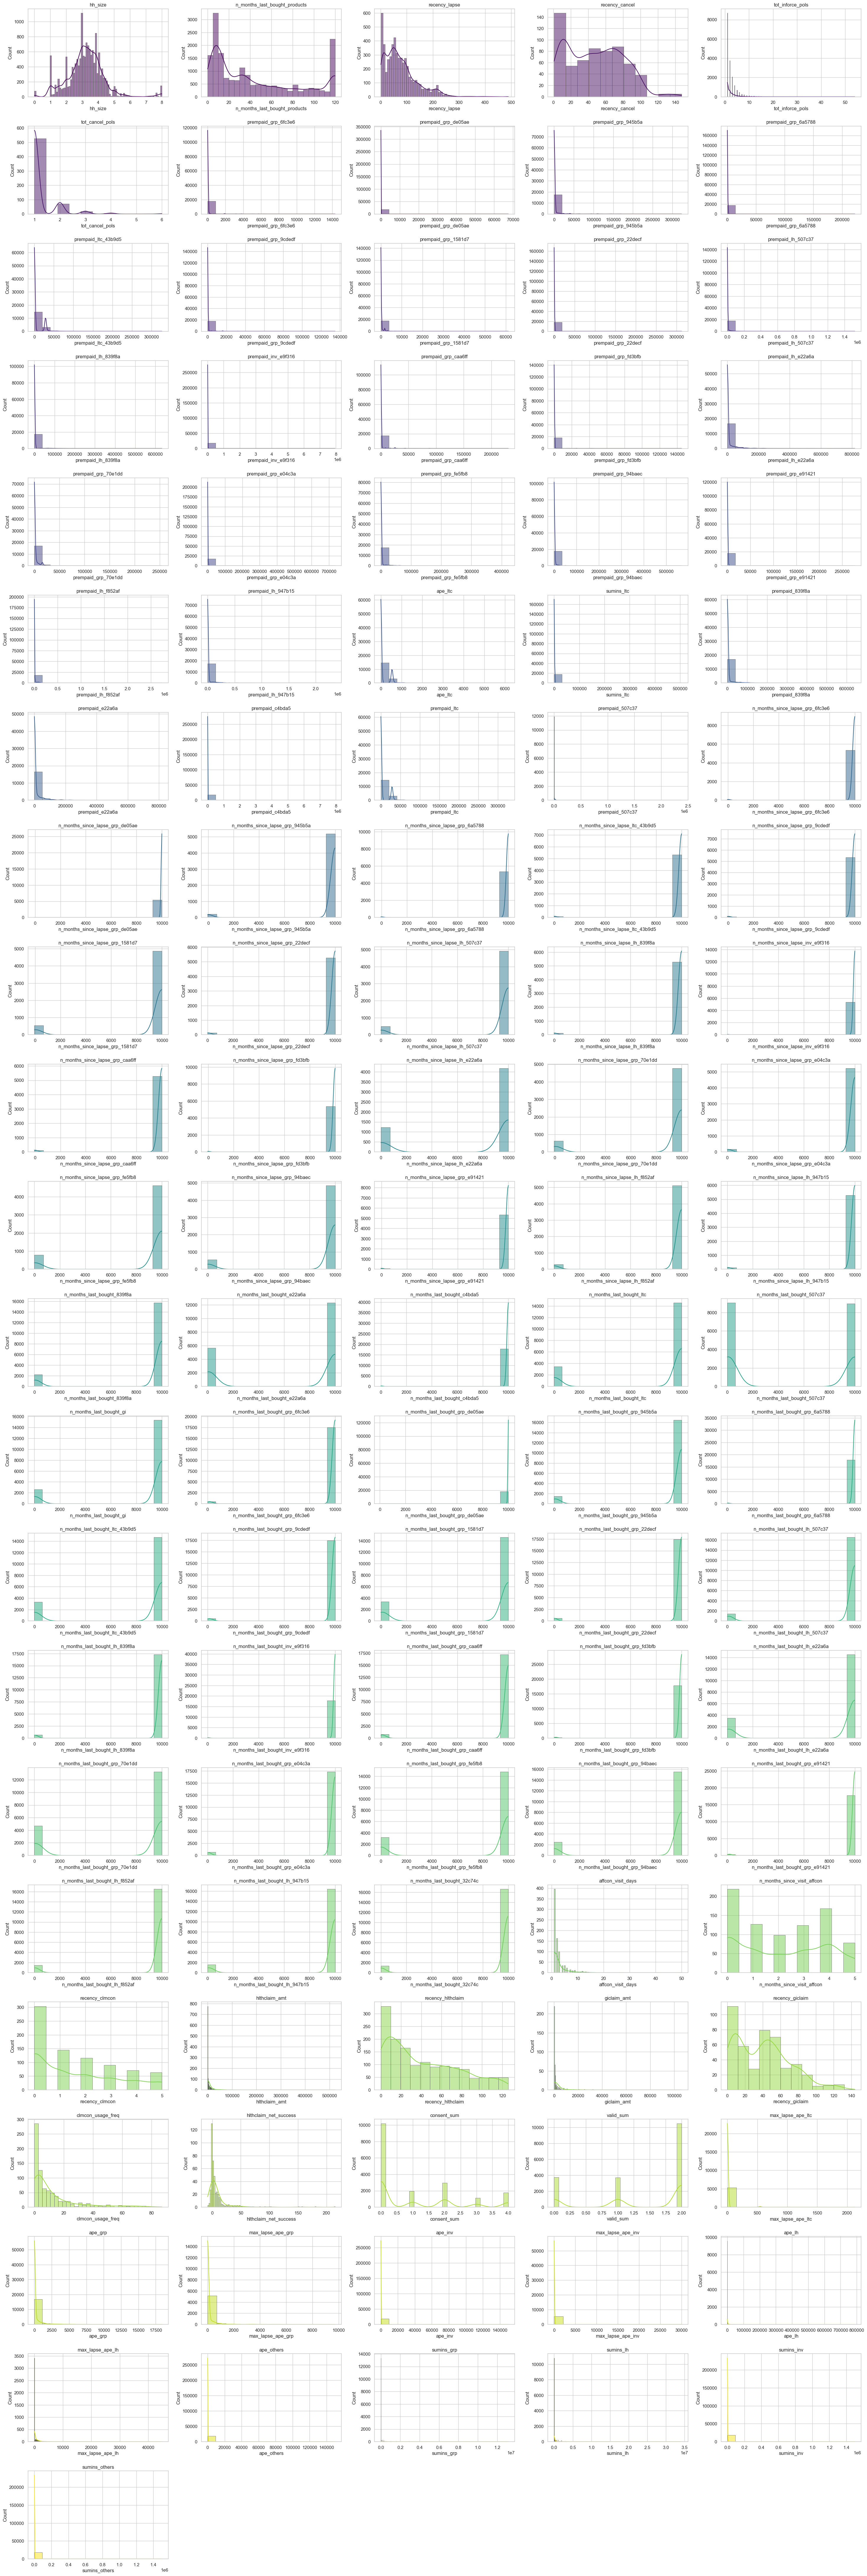

In [51]:
numerical_data = data.select_dtypes(include=['float64', 'int64'])
numerical_data = numerical_data.loc[:, numerical_data.nunique() > 2]
n = len(numerical_data.columns)
ncols = 5  
nrows = n // ncols + (n % ncols > 0)  

sns.set_theme(style="whitegrid")
palette = sns.color_palette("viridis", n)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*4))
fig.tight_layout(pad=4.0)

for i, col in enumerate(numerical_data.columns):
    
    row = i // ncols
    col_index = i % ncols
    ax = axs[row, col_index] if nrows > 1 else axs[col_index]
    sns.histplot(numerical_data[col], kde=True, ax=ax, color=palette[i % len(palette)],
                 edgecolor=".3", linewidth=.5)
    ax.set_title(col, fontsize=12)

# Adjust subplots that don't have a histogram (if any)
if n % ncols != 0:
    for empty in range(n, nrows * ncols):
        empty_row = empty // ncols
        empty_col = empty % ncols
        fig.delaxes(axs[empty_row][empty_col] if nrows > 1 else axs[empty_col])

plt.show()

### Drop 'clntnum' column bc it is a unique identifier & there are no duplicates in this column (meaning all clients are unique)

In [52]:
def drop_column(data, column_name):

    if column_name in data.columns:
        return data.drop(columns=[column_name])
    else:
        print(f"Column '{column_name}' not found in DataFrame.")
        return data

data_cleaned = drop_column(data, 'clntnum')

In [53]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17992 entries, 19550 to 15795
Columns: 202 entries, race_desc to sumins_others
dtypes: category(6), datetime64[ns](2), float64(114), int64(77), object(3)
memory usage: 27.1+ MB


### Drop columns with 100% null values

In [54]:
columns_to_drop = null_percentage[null_percentage == 100].index
columns_to_drop = [col for col in columns_to_drop if col != target and col in data_cleaned.columns]

data_cleaned = data_cleaned.drop(columns=columns_to_drop)

print(f"Columns dropped: {columns_to_drop}")
print(f"Shape of the cleaned DataFrame: {data_cleaned.shape}")

Columns dropped: []
Shape of the cleaned DataFrame: (17992, 202)


### Drop rows with 'None' values in either 'min_occ_date' or 'cltdob_fix' or both. This is because when there is 'None' values in at least 1 of the 2 columns, we are unable to calculate the age of the client ('min_occ_date' minus 'cltdob_fix')

### The % of 'None' values is very low anyway 
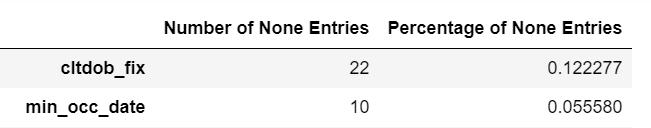

In [55]:
condition = (data_cleaned['min_occ_date'] == 'None') | (data_cleaned['cltdob_fix'] == 'None')

# Remove rows that satisfy the condition
data_cleaned = data_cleaned[~condition]

### Drop 'hh_20', 'pop_20' & 'hh_size_est' columns since the 'hh_20' divided by 'pop_20' gives values in an existing column 'hh_size', and 'hh_size_est' contains values rounded off from 'hh_size' 

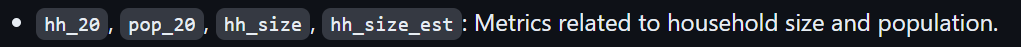

In [56]:
data_cleaned = data_cleaned.drop(['hh_20', 'pop_20', 'hh_size_est'], axis=1)

In [57]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17992 entries, 19550 to 15795
Columns: 199 entries, race_desc to sumins_others
dtypes: category(6), datetime64[ns](2), float64(114), int64(77)
memory usage: 26.7 MB




### Creating a column for clients' ages 



In [58]:
def calculate_decimal_age(data, date_column_1, date_column_2):

    # Ensure the date columns are in datetime format
    data[date_column_1] = pd.to_datetime(data[date_column_1])
    data[date_column_2] = pd.to_datetime(data[date_column_2])
    
    # Calculate age in decimal years
    data['client_age'] = (data[date_column_1] - data[date_column_2]).dt.total_seconds() / (365.25 * 24 * 60 * 60)

    # Drop the specified date columns
    data.drop(columns=[date_column_1, date_column_2], inplace=True)

    return data

calculate_decimal_age(data_cleaned, 'min_occ_date', 'cltdob_fix')
data_cleaned.head(20)

race_desc ctrycode_desc clttype stat_flag cltsex_fix  flg_substandard  \
19550   Chinese     Singapore       P    ACTIVE     Female              0.0   
4600    Chinese     Singapore       P    ACTIVE       Male              0.0   
13337    Others     Singapore       P    ACTIVE       Male              0.0   
15074   Chinese     Singapore       P    ACTIVE     Female              0.0   
19724   Chinese     Singapore       P    ACTIVE     Female              0.0   
14717   Chinese     Singapore       P    ACTIVE     Female              0.0   
6307    Chinese     Singapore       P    ACTIVE     Female              0.0   
4168     Indian     Singapore       P    ACTIVE     Female              0.0   
169     Chinese     Singapore       P    ACTIVE       Male              0.0   
11816   Chinese     Singapore       P    ACTIVE       Male              0.0   
14245   Chinese     Singapore       P    ACTIVE     Female              0.0   
4618    Chinese     Singapore       P    ACTIVE     Female              0.0   
11928       NaN     Singapore       G    ACTIVE       Male              0.0   
11195   Chinese     Singapore       P    ACTIVE       Male              0.0   
6492        NaN     Singapore       G    ACTIVE       Male              0.0   
10520   Chinese     Singapore       P    ACTIVE       Male              0.0   
18743       NaN     Singapore       G    ACTIVE     Female              NaN   
15299    Indian     Singapore       P    ACTIVE     Female              0.0   
17470   Chinese     Singapore       P    ACTIVE       Male              0.0   
17726   Chinese     Singapore       P    ACTIVE       Male              0.0   

       flg_is_borderline_standard  flg_is_revised_term  flg_is_rental_flat  \
19550                         0.0                  0.0                 0.0   
4600                          0.0                  0.0                 0.0   
13337                         0.0                  0.0                 0.0   
15074                         0.0                  0.0                 0.0   
19724                         0.0                  0.0                 0.0   
14717                         0.0                  0.0                 0.0   
6307                          0.0                  0.0                 0.0   
4168                          0.0                  0.0                 0.0   
169                           0.0                  0.0                 0.0   
11816                         0.0                  0.0                 0.0   
14245                         0.0                  0.0                 0.0   
4618                          0.0                  0.0                 0.0   
11928                         0.0                  0.0                 0.0   
11195                         0.0                  0.0                 0.0   
6492                          0.0                  0.0                 0.0   
10520                         0.0                  0.0                 0.0   
18743                         NaN                  NaN                 NaN   
15299                         0.0                  0.0                 0.0   
17470                         0.0                  0.0                 0.0   
17726                         0.0                  0.0                 0.0   

       flg_has_health_claim  ...  ape_inv  max_lapse_ape_inv  ape_lh  \
19550                   0.0  ...      0.0                0.0   636.0   
4600                    0.0  ...      0.0                0.0     0.0   
13337                   0.0  ...      0.0                NaN     0.0   
15074                   0.0  ...      0.0                NaN     0.0   
19724                   0.0  ...      0.0                NaN   696.0   
14717                   0.0  ...      0.0                NaN     0.0   
6307                    0.0  ...      0.0                NaN  1308.0   
4168                    0.0  ...      0.0                NaN     0.0   
169                     0.0  ...      0.0                Na

### Replacing null values in target column 

In [59]:
def clean_target_column(data, target_column_name):
    
    # Replace NaN values with 0
    data[target_column_name] = data[target_column_name].fillna(0)
    # Convert 1.0 to 1
    data[target_column_name] = data[target_column_name].apply(lambda x: 1 if x == 1.0 else x)
    
    return data

data_cleaned = clean_target_column(data_cleaned, target)

In [60]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for column in data_cleaned.columns:
    if data_cleaned[column].dtype == 'category':
        data_cleaned[column] = label_encoder.fit_transform(data_cleaned[column])



## K-Fold Split and Model Training 



In [61]:
n_splits = 5  
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    enable_categorical=True,
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.05,
    reg_alpha=0.1,
    reg_lambda=1.0,
)

auc_scores, log_losses, precisions, recalls, f1_scores = [], [], [], [], []

for train_index, val_index in kf.split(data_cleaned):
    
    tr, val = data_cleaned.iloc[train_index], data_cleaned.iloc[val_index]
    features = [col for col in data_cleaned.columns if col != target]

    clf.fit(tr[features], tr[target], verbose=True)

    val_probabilities = clf.predict_proba(val[features])[:, 1]
    val_predictions = (val_probabilities > 0.5).astype(int)

    # Calculate and store each metric
    auc_scores.append(roc_auc_score(val[target], val_probabilities))
    log_losses.append(log_loss(val[target], val_probabilities))
    precisions.append(precision_score(val[target], val_predictions))
    recalls.append(recall_score(val[target], val_predictions))
    f1_scores.append(f1_score(val[target], val_predictions))

# Calculate average of the metrics
avg_auc = np.mean(auc_scores)
avg_log_loss = np.mean(log_losses)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

# Print the average metrics
print(f"Average ROC AUC Score: {avg_auc}")
print(f"Average Log Loss: {avg_log_loss}")
print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1 Score: {avg_f1}")

Average ROC AUC Score: 0.8495514162418356
Average Log Loss: 0.1246570067320931
Average Precision: 0.7382839768926726
Average Recall: 0.13814695972129856
Average F1 Score: 0.23216271250192205


### Display columns and their feature importances 

In [62]:
DISPLAY = len(data_cleaned)
importance_data = pd.DataFrame({'name': clf.feature_names_in_, 'importance': clf.feature_importances_})
importance_data = importance_data.sort_values(by='importance', ascending=False)
print(importance_data.head(DISPLAY))

                                  name  importance
112            n_months_last_bought_gi    0.078373
165                           f_retail    0.061737
182                          valid_sum    0.056161
3                            stat_flag    0.027766
14                is_housewife_retiree    0.018959
150     n_months_last_bought_lh_839f8a    0.018879
105                   f_ever_bought_gi    0.018665
149     n_months_last_bought_lh_507c37    0.015075
176                  clmcon_usage_freq    0.015060
177              hlthclaim_net_success    0.013542
110           n_months_last_bought_ltc    0.013375
0                            race_desc    0.013104
162        n_months_last_bought_32c74c    0.012777
18                  f_ever_declined_la    0.012635
186                  max_lapse_ape_grp    0.012629
11                     flg_is_proposal    0.012496
57                       f_hold_839f8a    0.012076
92     n_months_since_lapse_grp_e04c3a    0.011719
160     n_months_last_bought_lh

### Drop features with feature importance of less than 0.002 for model re-training

In [63]:
zero_importance_features = importance_data[importance_data['importance'] <= 0.002]['name']

# Drop these features from the data_cleaned DataFrame
data_cleaned = data_cleaned.drop(columns=zero_importance_features)

In [64]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17992 entries, 19550 to 15795
Columns: 107 entries, race_desc to client_age
dtypes: float64(62), int32(5), int64(40)
memory usage: 14.5 MB


# Re-train the model

In [65]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    enable_categorical=True,
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.05,
    reg_alpha=0.1,
    reg_lambda=1.0,
)

auc_scores, log_losses, precisions, recalls, f1_scores = [], [], [], [], []

for train_index, val_index in kf.split(data_cleaned):
    
    tr, val = data_cleaned.iloc[train_index], data_cleaned.iloc[val_index]
    features = [col for col in data_cleaned.columns if col != target]

    clf.fit(tr[features], tr[target], verbose=True)
    val_probabilities = clf.predict_proba(val[features])[:, 1]
    val_predictions = (val_probabilities > 0.5).astype(int)

    # Calculate and store each metric
    auc_scores.append(roc_auc_score(val[target], val_probabilities))
    log_losses.append(log_loss(val[target], val_probabilities))
    precisions.append(precision_score(val[target], val_predictions))
    recalls.append(recall_score(val[target], val_predictions))
    f1_scores.append(f1_score(val[target], val_predictions))

# Calculate average of the metrics
avg_auc = np.mean(auc_scores)
avg_log_loss = np.mean(log_losses)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1 = np.mean(f1_scores)

# Print the average metrics
print(f"Average ROC AUC Score: {avg_auc}")
print(f"Average Log Loss: {avg_log_loss}")
print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1 Score: {avg_f1}")

Average ROC AUC Score: 0.8496053267014391
Average Log Loss: 0.12470881697150085
Average Precision: 0.7232717524021872
Average Recall: 0.13702739654594795
Average F1 Score: 0.22962035495537006
